<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/Coding_with_Qiskit_1_x_episode_5_dynamic_circuits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
### Qiskit 설치: Windows, 클라우드 환경 ###
%pip install qiskit[visualization]==1.2.4
%pip install qiskit-ibm-runtime==0.30.0
%pip install qiskit-transpiler-service==0.4.10
%pip install qiskit-aer==0.15.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 7.1 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=f3765af38b8d85911f694ea855753c96a40059e455d21200025832e4ffe1cd54
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [28]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum",
                               token="92bf1aa2435f7cc5f8ed32031b8dbdd43be540b92ca8e29e29ce81d79552606e2e2f309839ee297dc8177d7875512f473ca6c77230ec5cdbf4a5f98110da2f26",
                               instance="ibm-q/open/main")
service



<QiskitRuntimeService>

# Long-range CNOT gate teleportation using dynamic circuits

## Step 1: Map the problem to circuits and operators

In [29]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr

def get_dynamic_CNOT_circuit(num_qubit):
    """
    (1) 1D chain of nearest neighbors
    (2) 0th qubit is the control, and the last qubit (num_qubit-1) is the target
    (3) The control qubit starts in the + state
    """
    num_ancilla = num_qubit - 2
    num_ancilla_pair = int(num_ancilla / 2)

    qr = QuantumRegister(num_qubit)
    cr1 = ClassicalRegister(num_ancilla_pair, name="cr1") # The parity-controlled X gate
    cr2 = ClassicalRegister(num_ancilla - num_ancilla_pair, name="cr2") # The parity-controlled Z gate
    cr3 = ClassicalRegister(2, name="cr3") # For the final measurements on the control and target qubits
    qc = QuantumCircuit(qr, cr1, cr2, cr3)

    # Initialize the control qubit
    qc.h(0)
    qc.barrier()

    # Entangle the contorl qubit and the first ancilla qubit
    qc.cx(0,1)

    # Create Bell pairs on ancilla qubits
    # The first ancilla qubit in index 1
    for i in range(num_ancilla_pair):
        qc.h(2+2*i)
        qc.cx(2+2*i, 2+2*i+1)
    ###for

    # Prepare Bell pairs on staggered ancilla and data qubits
    for i in range(num_ancilla_pair+1):
        qc.cx(1+2*i, 1+2*i+1)
    ###for

    for i in range(1, num_ancilla_pair+2):
        qc.h(2*i-1)
    ###for

    # Measurement on alternating ancilla qubits starting with the first one
    # Keep track of the parity for eventual conditional Z gate
    for i in range(1, num_ancilla_pair+2):
        qc.measure(2*i - 1, cr2[i-1])
        if i == 1:
            parity_control = expr.lift(cr2[i-1])
        else:
            parity_control = expr.bit_xor(cr2[i-1], parity_control)
        ###if
    ###for

    # Measurement on staggered alternating ancilla qubits starting with the second
    # Keep track of the parity of eventual conditional X gate
    for i in range(num_ancilla_pair):
        qc.measure(2*i + 2, cr1[i])
        if i == 0:
            parity_target = expr.lift(cr1[i])
        else:
            parity_target = expr.bit_xor(cr1[i], parity_target)
        ###if

    with qc.if_test(parity_control):
        qc.z(0)
    ###with

    with qc.if_test(parity_target):
        qc.x(-1)
    ###with

    # Final measurements on the control and target qubits
    qc.measure(0, cr3[0])
    qc.measure(-1, cr3[1])

    return qc
###def

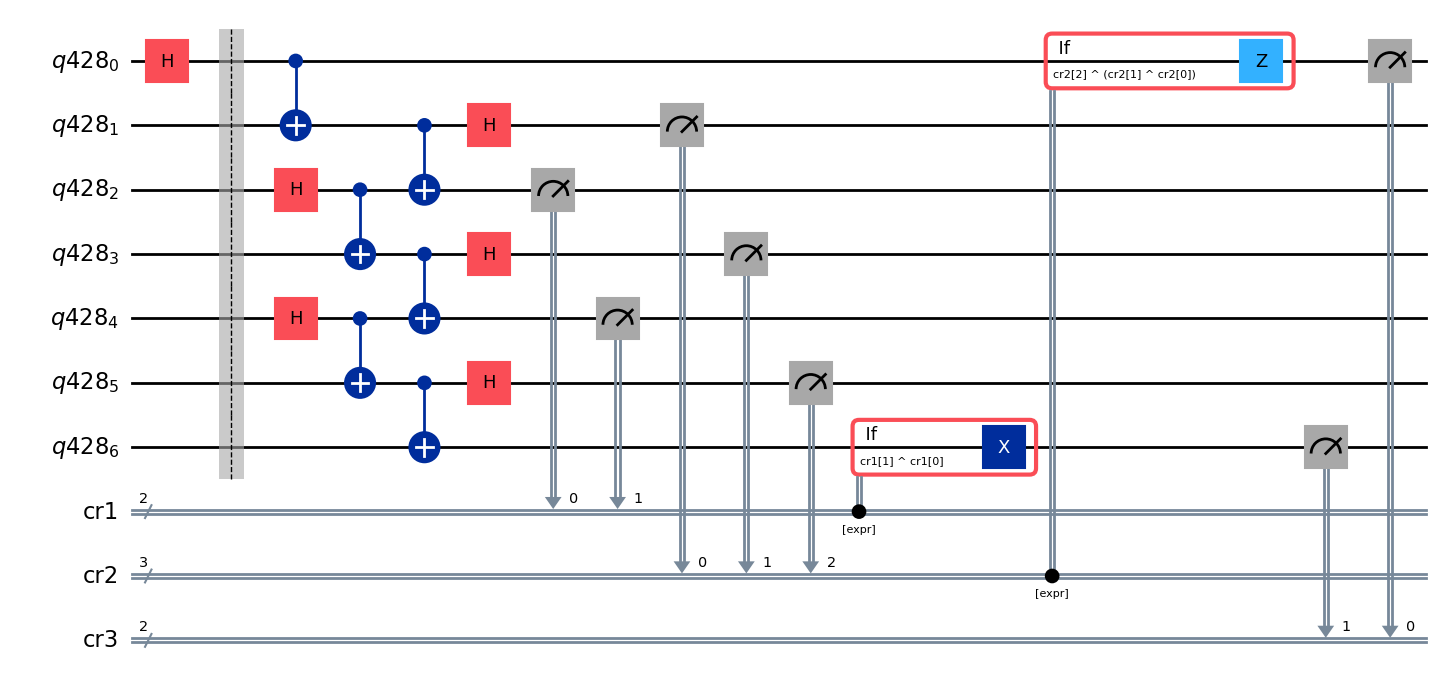

In [30]:
qc = get_dynamic_CNOT_circuit(num_qubit=7)
qc.draw(output='mpl')

In [40]:
#max_num_qubit = 41
max_num_qubit = 21

qc_list = []
num_qubit_list = list(range(7, max_num_qubit+1, 2))
for num_qubit in num_qubit_list:
    qc_list.append(get_dynamic_CNOT_circuit(num_qubit))

## Step 2: Optimize the problem for quantum execution

In [41]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager#
#from qiskit_ibm_runtime import QiskitRuntimeService

#service = QiskitRuntimeService()
backend = service.backend(name='ibm_kyiv')
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled_list = pm.run(qc_list)

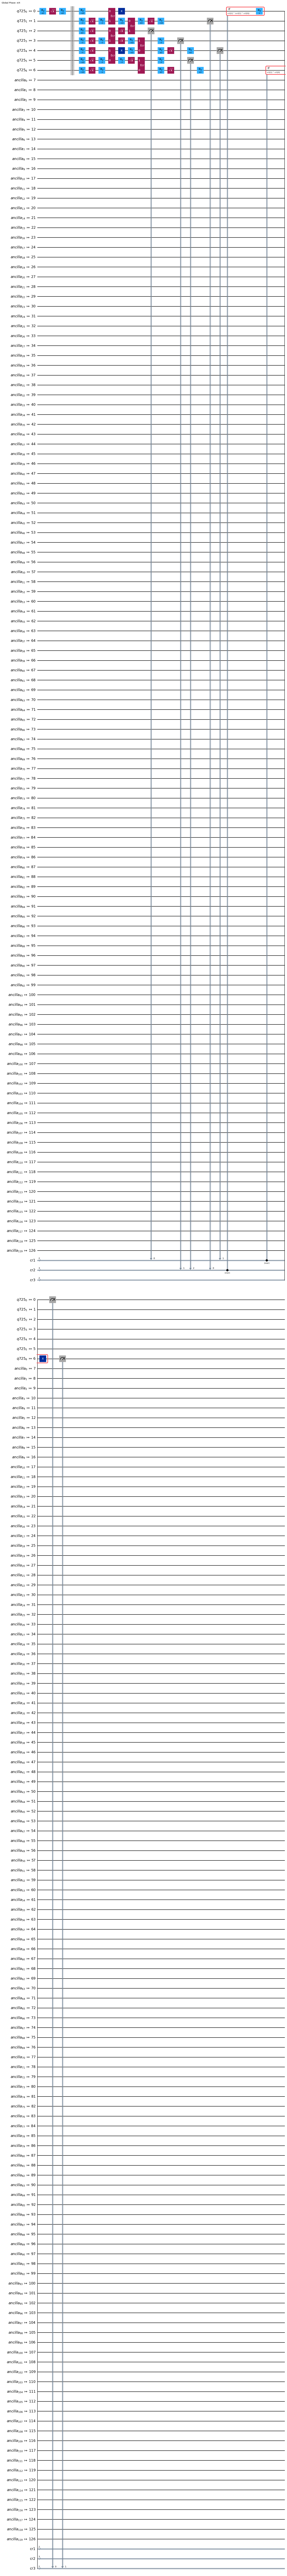

In [42]:
qc_transpiled_list[0].draw(output='mpl')

## Step 3: Execute the circuit

In [43]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend)
job = sampler.run(qc_transpiled_list)
print(job.job_id())

KeyError: Qubit(QuantumRegister(7, 'q725'), 6)

## Step 4: Post-processing (and plotting)

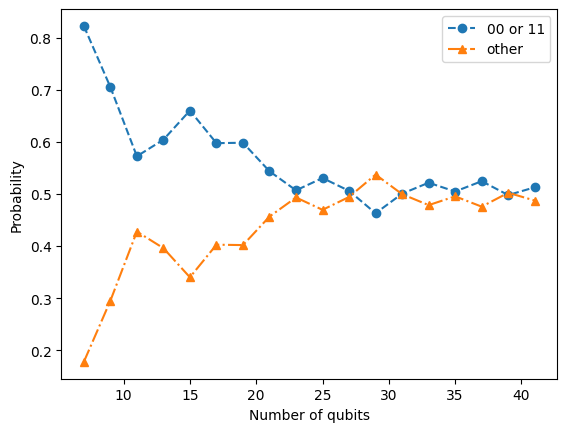

In [ ]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService

job_id = 'crbf06rc90400089gk8g' # Cusco, documentation provider, max_qubit=41, new image

service = QiskitRuntimeService()
job = service.job(job_id)
result = job.result()

list_Bell = []
list_other = []
for i in range(0, len(qc_list)):
    data = result[i].data
    counts = data.cr3.get_counts()
    total_counts = data.cr3.num_shots

    prob_Bell = (counts['00'] + counts['11']) / total_counts

    list_Bell.append(prob_Bell)
    list_other.append(1-prob_Bell)

plt.plot(num_qubit_list, list_Bell, '--o', label='00 or 11')
plt.plot(num_qubit_list, list_other, '-.^', label='other')
plt.xlabel('Number of qubits')
plt.ylabel('Probability')
plt.legend()